## Felles import for alle kodeblokker

In [1]:
import sys
sys.path.append("../analysis")
from monthly_statistics import MonthlyStatistics
from analyses import DataAnalyzer

import pandas as pd
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

from dash import Dash, html, dcc, Input, Output, callback, no_update
import calendar
import re

analyzer = DataAnalyzer("../../data/processed")
stats = MonthlyStatistics("../../data/processed")

## Totalt nedbørsmengde per år

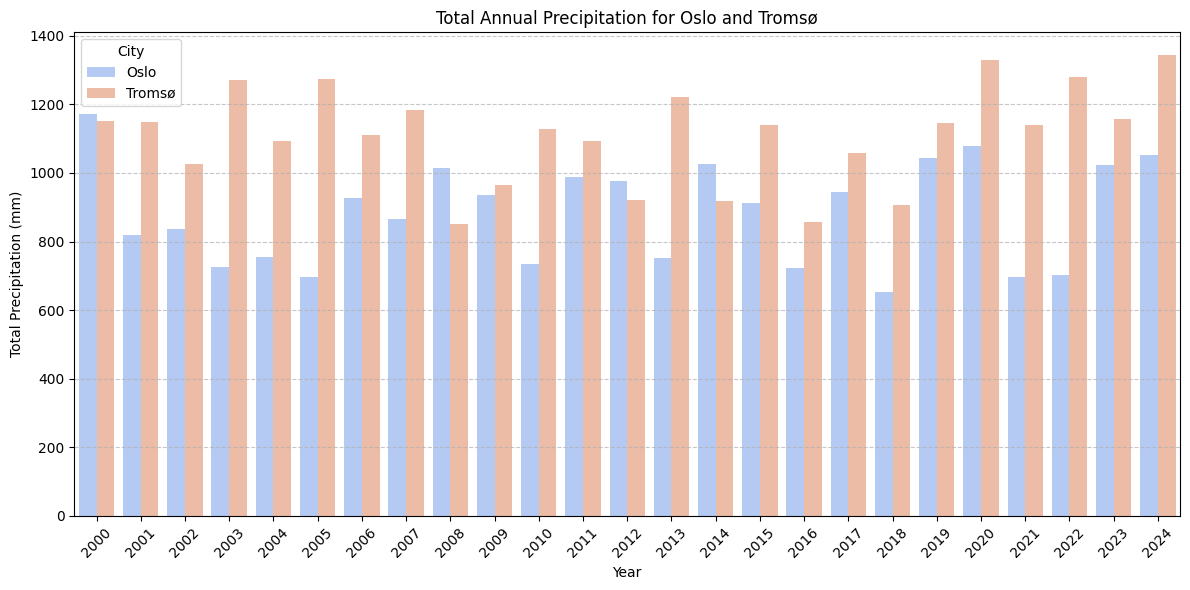

In [2]:
# Filstier til dataene
oslo_csv = "../../data/processed/vaerdata_oslo.csv"
tromso_csv = "../../data/processed/vaerdata_tromso.csv"

# Leser inn dataene
df_oslo = pd.read_csv(oslo_csv)
df_tromso = pd.read_csv(tromso_csv)

# Filtrerer dataene for nedbør (precipitation) og lager eksplisitte kopier
df_oslo_precipitation = df_oslo[
    (df_oslo['elementId'] == 'sum(precipitation_amount P1D)') & 
    (df_oslo['timeOffset'] == 'PT18H')
].copy()
df_tromso_precipitation = df_tromso[
    (df_tromso['elementId'] == 'sum(precipitation_amount P1D)') & 
    (df_tromso['timeOffset'] == 'PT18H')
].copy()

# Konverterer 'referenceTime' til datetime for korrekt gruppering
df_oslo_precipitation['referenceTime'] = pd.to_datetime(df_oslo_precipitation['referenceTime'])
df_tromso_precipitation['referenceTime'] = pd.to_datetime(df_tromso_precipitation['referenceTime'])

# Legger til en kolonne for år
df_oslo_precipitation['year'] = df_oslo_precipitation['referenceTime'].dt.year
df_tromso_precipitation['year'] = df_tromso_precipitation['referenceTime'].dt.year

# Summerer nedbørsmengden per år
annual_oslo_precipitation = df_oslo_precipitation.groupby('year')['value'].sum().reset_index()
annual_tromso_precipitation = df_tromso_precipitation.groupby('year')['value'].sum().reset_index()

# Legger til en kolonne for by
annual_oslo_precipitation['city'] = 'Oslo'
annual_tromso_precipitation['city'] = 'Tromsø'

# Kombinerer dataene for Oslo og Tromsø
annual_precipitation = pd.concat([annual_oslo_precipitation, annual_tromso_precipitation])

# Visualiserer dataene med Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=annual_precipitation, x='year', y='value', hue='city', palette='coolwarm')

# Legger til tittel og akseetiketter
plt.title('Total Annual Precipitation for Oslo and Tromsø')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
plt.xticks(rotation=45)
plt.legend(title='City')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Viser grafen
plt.tight_layout()
plt.show()

## Tempratur forskjell by

In [3]:
# Hent ferdigberegnet temperaturspenn (range) for begge byer
df_oslo = stats.compute_all_months("range(air_temperature P1D)", "oslo", time_offset="PT18H")
df_tromso = stats.compute_all_months("range(air_temperature P1D)", "tromso", time_offset="PT18H")

# Legg til 'year' og 'month'-kolonner
for df in [df_oslo, df_tromso]:
    df["year_month"] = pd.to_datetime(df["year_month"])
    df["year"] = df["year_month"].dt.year
    df["month"] = df["year_month"].dt.month_name()
    df["temp_diff"] = df["mean"]  # Gi nytt navn for bruk i figuren

# Start Dash-app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Temperature Range (Difference) per Month"),
    html.Label("City:"),
    dcc.Dropdown(
        id='city-dropdown',
        options=[{'label': 'Oslo', 'value': 'Oslo'}, {'label': 'Tromsø', 'value': 'Tromsø'}],
        value='Oslo'
    ),
    html.Label("Month:"),
    dcc.Dropdown(
        id='month-dropdown',
        options=[{'label': m, 'value': m} for m in calendar.month_name[1:]],
        value='January'
    ),
    html.Label("Start Year:"),
    dcc.Input(id='start-year', type='number', value=2000, min=2000, max=2023),
    html.Label("End Year:"),
    dcc.Input(id='end-year', type='number', value=2023, min=2000, max=2023),
    dcc.Graph(id='temperature-graph')
])

@app.callback(
    Output('temperature-graph', 'figure'),
    Input('city-dropdown', 'value'),
    Input('month-dropdown', 'value'),
    Input('start-year', 'value'),
    Input('end-year', 'value')
)
def update_graph(city, month, start_year, end_year):
    if city == "Oslo":
        df_filtered = df_oslo[
            (df_oslo["year"] >= start_year) &
            (df_oslo["year"] <= end_year) &
            (df_oslo["month"] == month)
        ]
    elif city == "Tromsø":
        df_filtered = df_tromso[
            (df_tromso["year"] >= start_year) &
            (df_tromso["year"] <= end_year) &
            (df_tromso["month"] == month)
        ]
    else:
        return px.bar(title="No Data Available")

    fig = px.bar(
        df_filtered,
        x="year",
        y="temp_diff",
        color="temp_diff",
        color_continuous_scale="YlOrRd",
        title=f"Average Temperature Range for {month} – {city} ({start_year} to {end_year})",
        labels={"temp_diff": "Temp. Range (°C)", "year": "Year"}
    )
    return fig

if __name__ == '__main__':
    app.run(debug=True)

## Manglende verdier

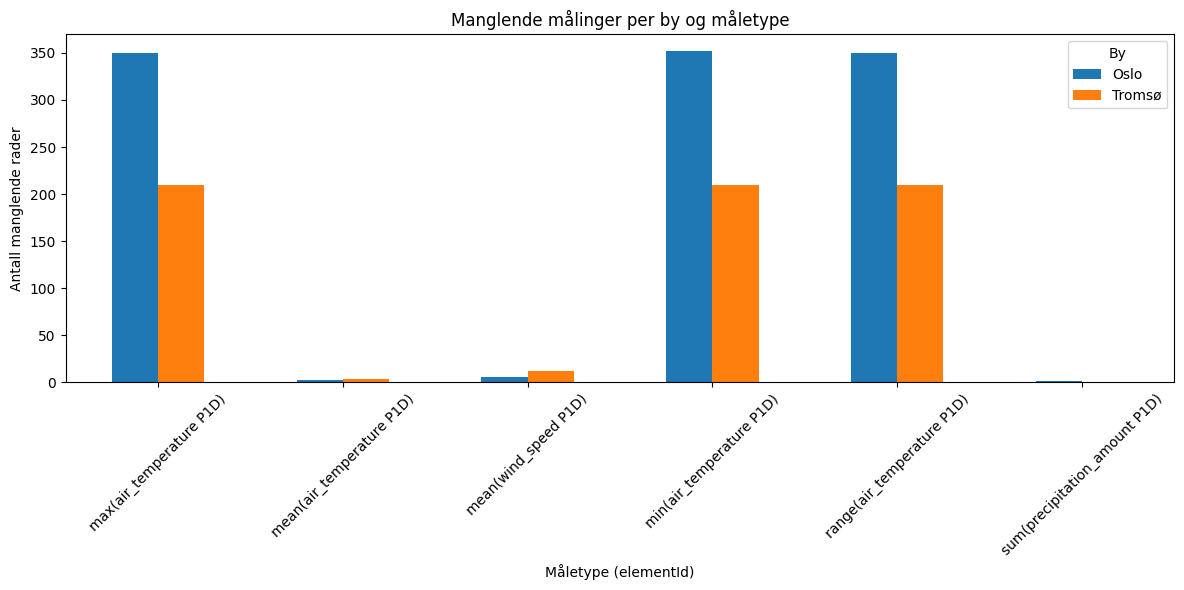

In [4]:
# 1. Les inn oppsummert data
df = pd.read_csv("../../data/missing/missing_summary.csv")

# 2. Fjern eventuelle whitespaces (valgfritt, men trygt)
df.columns = df.columns.str.strip()
df['city'] = df['city'].astype(str).str.strip()
df['elementId'] = df['elementId'].astype(str).str.strip()

# 3. Pivotér for visualisering
pivoted = df.pivot(index='elementId', columns='city', values='num_missing').fillna(0)

# 4. Plot
pivoted.plot(kind='bar', figsize=(12, 6))
plt.title('Manglende målinger per by og måletype')
plt.xlabel('Måletype (elementId)')
plt.ylabel('Antall manglende rader')
plt.xticks(rotation=45)
plt.legend(title='By')
plt.tight_layout()
plt.show()

## Interaktiv versjon av manglende data

In [5]:
# --- 1. Les inn aggregert data over manglende verdier ---
df_missing = pd.read_csv("../../data/missing/missing_summary.csv")

# Rens kolonner og verdier
df_missing.columns = df_missing.columns.str.strip()
df_missing["city"] = df_missing["city"].astype(str).str.strip()
df_missing["elementId"] = df_missing["elementId"].astype(str).str.strip()

# --- 2. Start Dash-applikasjonen ---
app = Dash(__name__)

# Lag liste over unike måltyper og byer
elements = sorted(df_missing["elementId"].unique())
cities = sorted(df_missing["city"].unique())

# --- 3. Layout ---
app.layout = html.Div([
    html.H1("Manglende Værdata per By og Måletype"),

    html.Label("Måletype:"),
    dcc.Dropdown(
        id="element-dropdown",
        options=[{"label": e, "value": e} for e in elements],
        value=elements[0]
    ),

    html.Label("By(er):"),
    dcc.Checklist(
        id="city-checklist",
        options=[{"label": c, "value": c} for c in cities],
        value=cities,
        labelStyle={"display": "inline-block", "margin-right": "10px"}
    ),

    dcc.Graph(id="missing-graph")
])

# --- 4. Callback for oppdatering av figur ---
@app.callback(
    Output("missing-graph", "figure"),
    Input("element-dropdown", "value"),
    Input("city-checklist", "value")
)
def update_graph(elementId, selected_cities):
    # Filtrer datasettet
    filtered = df_missing[
        (df_missing["elementId"] == elementId) &
        (df_missing["city"].isin(selected_cities))
    ]

    # Lag stolpediagram
    fig = px.bar(
        filtered,
        x="city",
        y="num_missing",
        color="city",
        title=f"Manglende målinger for '{elementId}'",
        labels={"num_missing": "Antall manglende målinger", "city": "By"},
        text="num_missing"
    )

    fig.update_layout(template="plotly_white")
    return fig

# --- 5. Start server ---
if __name__ == '__main__':
    app.run(debug=True)

## Gjennomsnittlig vindhastighet per måned

In [6]:
# 1. Hent gjennomsnitt per måned for Oslo og Tromsø for vind
oslo_df = stats.compute_all_months(
            element_id="sum(precipitation_amount P1D)",
            city="Oslo",
            time_offset="PT18H"
            )

tromso_df = stats.compute_all_months(
            element_id="sum(precipitation_amount P1D)",
            city="Tromso",
            time_offset="PT18H"
            )
# 2. Konverter 'year_month' til datetime for plotting
oslo_df["year_month"] = pd.to_datetime(oslo_df["year_month"])
tromso_df["year_month"] = pd.to_datetime(tromso_df["year_month"])

# 3. Lag graf med Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=oslo_df["year_month"],
    y=oslo_df["mean"],
    mode="lines+markers",
    name="Oslo",
    line=dict(color="blue"),
    marker=dict(size=6)
))

fig.add_trace(go.Scatter(
    x=tromso_df["year_month"],
    y=tromso_df["mean"],
    mode="lines+markers",
    name="Tromsø",
    line=dict(color="red"),
    marker=dict(size=6)
))

fig.update_layout(
    title="Gjennomsnittlig vindhastighet per måned i Oslo og Tromsø",
    xaxis_title="Tid",
    yaxis_title="Vindhastighet (m/s)",
    template="plotly_white",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()

## Antall sommerdager per år

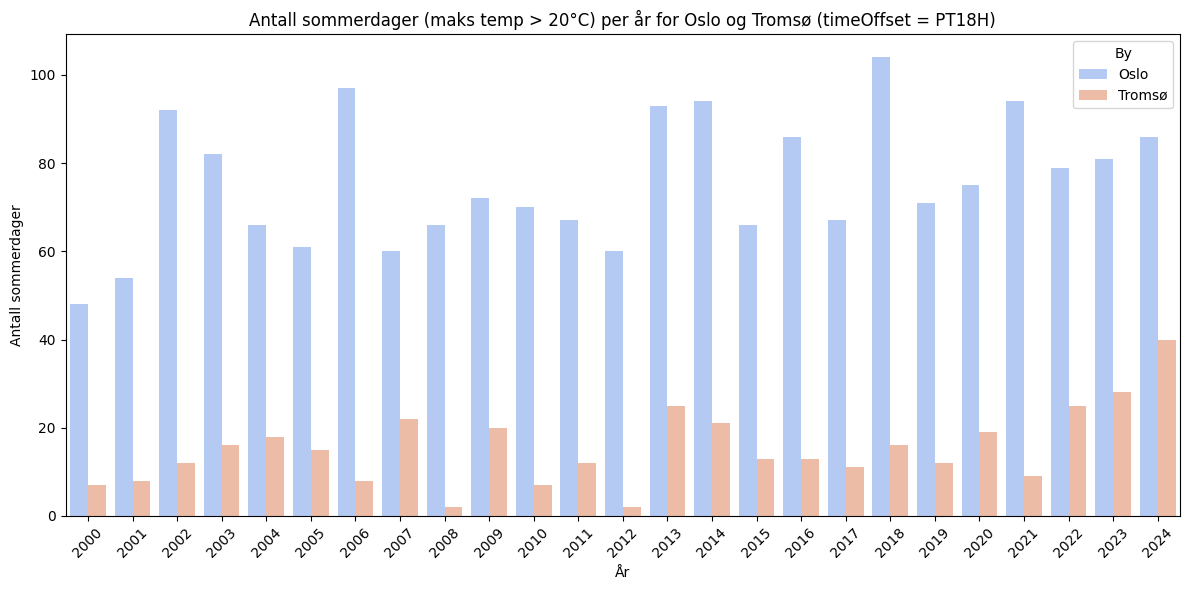

In [7]:
# Filstier til dataene
oslo_csv = "../../data/processed/vaerdata_oslo.csv"
tromso_csv = "../../data/processed/vaerdata_tromso.csv"

# Leser inn dataene
df_oslo = pd.read_csv(oslo_csv)
df_tromso = pd.read_csv(tromso_csv)

# Leser inn dataene
df_oslo = pd.read_csv(oslo_csv)
df_tromso = pd.read_csv(tromso_csv)

# Konverter 'referenceTime' til datetime-format
df_oslo['referenceTime'] = pd.to_datetime(df_oslo['referenceTime'])
df_tromso['referenceTime'] = pd.to_datetime(df_tromso['referenceTime'])

# Legg til kolonner for år og dag
df_oslo['year'] = df_oslo['referenceTime'].dt.year
df_oslo['day'] = df_oslo['referenceTime'].dt.date
df_tromso['year'] = df_tromso['referenceTime'].dt.year
df_tromso['day'] = df_tromso['referenceTime'].dt.date

# Filtrer dataene for maks temperatur med timeOffset = PT18H for Oslo og Tromsø
df_oslo_max = df_oslo[(df_oslo["elementId"] == "max(air_temperature P1D)") & (df_oslo["timeOffset"] == "PT18H")][["day", "year", "value"]].rename(columns={"value": "temp_max"})
df_tromso_max = df_tromso[(df_tromso["elementId"] == "max(air_temperature P1D)") & (df_tromso["timeOffset"] == "PT18H")][["day", "year", "value"]].rename(columns={"value": "temp_max"})

# Filtrer ut sommerdager (dager med maks temperatur over 20 grader)
df_oslo_sommerdager = df_oslo_max[df_oslo_max["temp_max"] > 20]
df_tromso_sommerdager = df_tromso_max[df_tromso_max["temp_max"] > 20]

# Tell antall sommerdager per år for hver by
oslo_sommerdager_per_år = df_oslo_sommerdager.groupby("year").size().reset_index(name="sommerdager")
tromso_sommerdager_per_år = df_tromso_sommerdager.groupby("year").size().reset_index(name="sommerdager")

# Legg til en kolonne for by
oslo_sommerdager_per_år["by"] = "Oslo"
tromso_sommerdager_per_år["by"] = "Tromsø"

# Kombiner dataene for begge byene
sommerdager_per_år = pd.concat([oslo_sommerdager_per_år, tromso_sommerdager_per_år])

# Visualiser dataene med Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=sommerdager_per_år, x="year", y="sommerdager", hue="by", palette="coolwarm")
plt.title("Antall sommerdager (maks temp > 20°C) per år for Oslo og Tromsø (timeOffset = PT18H)")
plt.xlabel("År")
plt.ylabel("Antall sommerdager")
plt.xticks(rotation=45)
plt.legend(title="By")
plt.tight_layout()
plt.show()

## Antall eksterm regn verdier for Oslo

In [8]:
by = "Oslo"  # Byen du vil analysere

df_outliers = analyzer.finn_outliers_per_maaned(
    by=by,
    element_id="sum(precipitation_amount P1D)",
    time_offset="PT18H",
    vis_tomme_maaneder=True
)

# 2. Konverter 'year_month' til dato og lag visningsvennlig måned/år
df_outliers["year_month"] = pd.to_datetime(df_outliers["year_month"])
df_outliers["måned"] = df_outliers["year_month"].dt.strftime("%b %Y")  # f.eks. "Jan 2000"

# 3. Lag figur med kun én y-akse (antall outliers)
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_outliers["måned"],
    y=df_outliers["outliers_removed"],
    name="Antall outliers",
    mode="lines+markers",
    line=dict(color="firebrick"),
    marker=dict(size=6)
))

# 4. Layout
fig.update_layout(
    title=f"Antall outliers per måned for nedbør i {by}",
    xaxis=dict(title="Måned", tickangle=45),
    yaxis=dict(title="Antall outliers"),
    template="plotly_white"
)

fig.show()

## Interaktiv versjon for visning antall ekstrem verdier

In [9]:
cities = ["oslo", "tromso"]
element_ids = [
    "mean(air_temperature P1D)",
    "mean(wind_speed P1D)",
    "max(air_temperature P1D)",
    "min(air_temperature P1D)",
    "range(air_temperature P1D)",
    "sum(precipitation_amount P1D)"
]

app = Dash(__name__)
app.title = "Outlier‑visualisering"

app.layout = html.Div(
    style={"maxWidth": "900px", "margin": "auto"},
    children=[
        html.H1("Ekstremverdier (Outliers) per måned"),

        html.Label("By:"),
        dcc.Dropdown(
            id="city-dropdown",
            options=[{"label": c.capitalize(), "value": c} for c in cities],
            value=cities[0],
            clearable=False,
        ),

        html.Label("Måletype (elementId):"),
        dcc.Dropdown(
            id="element-dropdown",
            options=[{"label": e, "value": e} for e in element_ids],
            value="sum(precipitation_amount P1D)",
            clearable=False,
        ),

        html.Label("Vis måneder uten outliers:"),
        dcc.Checklist(
            id="toggle-empty-months",
            options=[{"label": "Ja", "value": "vis"}],
            value=["vis"],
            inline=True,
        ),

        dcc.Graph(id="outlier-graph"),
    ],
)

# ---------- 3. Callback: tegn figur -----------------------------------------
@app.callback(
    Output("outlier-graph", "figure"),
    Input("city-dropdown", "value"),
    Input("element-dropdown", "value"),
    Input("toggle-empty-months", "value"),
)
def update_outlier_graph(city, element_id, show_empty_months):
    """Oppdater grafen når brukeren endrer valg."""
    vis_tomme = "vis" in show_empty_months

    # laveste offset hentes automatisk:
    offset = analyzer._laveste_offset(city, element_id)

    df_outliers = analyzer.finn_outliers_per_maaned(
        by=city,
        element_id=element_id,
        time_offset=offset,
        vis_tomme_maaneder=vis_tomme,
    )

    # gjør dato penere på x‑aksen
    df_outliers["year_month"] = pd.to_datetime(df_outliers["year_month"])
    df_outliers["måned"] = df_outliers["year_month"].dt.strftime("%b %Y")

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df_outliers["måned"],
            y=df_outliers["outliers_removed"],
            name="Antall outliers",
            mode="lines+markers",
            marker=dict(size=6),
            line=dict(color="firebrick"),
        )
    )

    fig.update_layout(
        title=f"Antall outliers per måned – {element_id} i {city.capitalize()} (Offset {offset})",
        xaxis=dict(title="Måned", tickangle=45),
        yaxis=dict(title="Antall outliers"),
        template="plotly_white",
    )
    return fig


# ---------- 4. Kjør server ---------------------------------------------------
if __name__ == "__main__":
    app.run(debug=True)
